# Unsupervised Learning for Pais Trading: Pairs Selection

##  1) Clustering

### 1.1) Importing libraries

In [92]:
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D

import random

from scipy.stats import multivariate_normal

import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, AffinityPropagation, Birch, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn import cluster, covariance, manifold
from sklearn.neighbors import KernelDensity
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, ward, dendrogram

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


sns.set_style('white')


In [3]:
import requests
import bs4 as bs
import yfinance as yf

In [4]:
import warnings
warnings.filterwarnings('ignore')

### 1.2) Helper Functions

In [15]:
def plot_kmeans_density(X, y_pred, cluster_centers, resolution=1000):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), np.linspace(mins[1], maxs[1], resolution))
    
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, linewidths=1, colors='r', linestyles='--')


    plt.plot(X[:, 0], X[:, 1], 'k.', markersize = 6)
    

    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
    

    for i, center in enumerate(cluster_centers):
        cluster_data = X[y_pred == i]
        
        kde = KernelDensity(bandwidth=0.2)
        kde.fit(cluster_data)
        
        log_density = kde.score_samples(np.c_[xx.ravel(), yy.ravel()])
        density = np.exp(log_density)
        density = density.reshape(xx.shape)
        
        plt.contour(xx, yy, density, levels=np.linspace(0, density.max(), 6), linewidths=1, cmap = 'viridis')

    plt.title('KMeans Clustering with Density Contours')
    plt.xlabel('Mean return')
    plt.ylabel('Volatility')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    line = Line2D([0], [0], label = 'decision boundaries', color ='r', linestyle = '--')
    handles.extend([line])

    plt.legend(handles = handles)
    
    plt.show()

In [76]:
def plot_centroids(centroids, weights = None):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.plot(centroids[:, 0], centroids[:, 1], 'yX', markersize = 10, label = 'Centroids')

In [77]:
def plot_gmm(model, X, y_pred, means, covariances, resolution = 1000):
    mins = X.min(axis = 0) - .1
    maxs = X.max(axis = 0) + .1
    
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), np.linspace(mins[1], maxs[1], resolution))
    Z = - model.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, norm = LogNorm(vmin = 1, vmax = 30), levels = np.logspace(0, 2, 20),
                linewidths = 1.5, cmap = 'viridis')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize = 6)
    
    plot_centroids(model.means_, model.weights_)
    
    
    for i in range(len(means)):
        mean = means[i]
        cov = covariances[i][:2, :2]
        mvn = multivariate_normal(mean, cov)
        
        pos = np.dstack((xx, yy))
        density = mvn.pdf(pos)
        
        plt.contour(xx, yy, density, levels = np.linspace(0, density.max(), 3),
                    linewidths = 1, colors = 'k', alpha = 1 )

        
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, linewidths = 1, colors = 'r', linestyles = '--')
        
        
    plt.title('Gaussian Mixture Model')
    plt.xlabel('Mean return')
    plt.ylabel('Volatility')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    line = Line2D([0], [0], label = 'decision boundaries', color ='r', linestyle = '--')
    handles.extend([line])

    plt.legend(handles = handles)
    
    plt.show()

### 1.3) Scrapping S&P500 data

In [7]:
requ = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
bsoup = bs.BeautifulSoup(requ.text, 'lxml')
table = bsoup.find('table', {'class': 'wikitable sortable'})

In [8]:
tickers = []
for i in table.findAll('tr')[1:]:
    ticker = i.findAll('td')[0].text
    tickers.append(ticker)

In [9]:
tickers = [i.replace('\n', '') for i in tickers]

In [10]:
end = dt.datetime.today()
start = end - relativedelta(years = 15)

In [11]:
df = yf.download(tickers, start = start, end = end)['Close']

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found for this date range, symbol may be delisted


In [12]:
df = df.dropna(how = 'any', axis = 1)

In [17]:
df.to_csv('raw_data.csv')

### 1.4) EDA

In [ ]:
df.iloc[:, 1:5].plot(subplots = True, figsize = (15, 6), layout = (3, 2), color = 'black', lw = 1, rot=0)
plt.show()

In [ ]:
sns.pairplot(df.iloc[:, 1:10], plot_kws = {'color': 'blue', 'marker': 's'}, diag_kws = {'color': 'black'})
sns.despine()

### 1.5) Data Processing

In [18]:
asset_returns = df.pct_change().mean() * 252
asset_volatility = df.pct_change().std() * np.sqrt(252)
features = pd.DataFrame({'Returns': asset_returns, 'Volatility': asset_volatility})

In [19]:
sc = StandardScaler().fit(features)
sc_fit = sc.fit_transform(features)
scaled_features = pd.DataFrame(sc_fit, columns = features.columns, index = features.index)

In [20]:
scaled_features.to_csv(path + 'pairs_data.csv')

### 1.6) Clustering Models

### 1.6.1. K-Means

#### Hyperparameter selection

In [21]:
inertia = []
for i in range(2, 30):
    kmeans = KMeans(i, random_state = 42, n_init = 10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

Text(0, 0.5, 'Inertia')

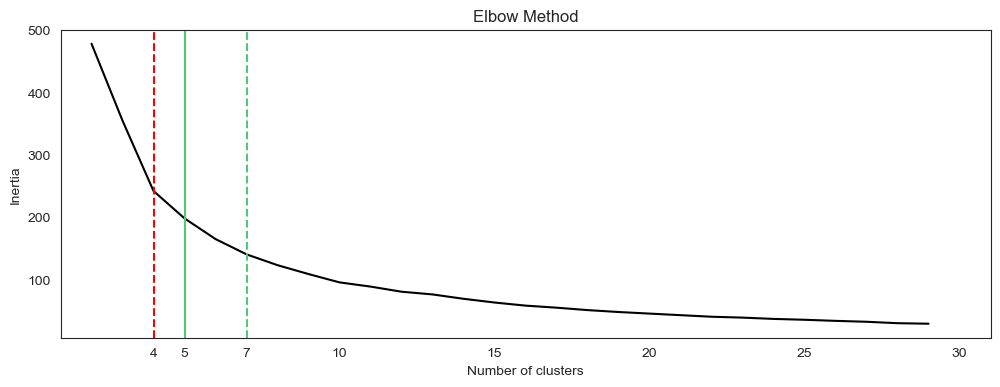

In [22]:
fig = plt.figure(figsize = (12, 4))
ax = fig.add_subplot()
ax.plot(range(2, 30), inertia, color = 'black')
ax.axvline(4, color = 'red', linestyle = '--')
ax.axvline(5, color = '#50C878')
ax.axvline(7, color = '#50C878', linestyle = '--')
x_ticks = np.append(ax.get_xticks(), [4, 7])
ax.set_xticks(x_ticks)
plt.xlim([1, 31])
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [23]:
silhouette = []
for i in range(2, 30):
    kmeans = KMeans(i, random_state = 42, n_init = 10)
    kmeans.fit(scaled_features)
    silhouette.append(metrics.silhouette_score(scaled_features, kmeans.labels_, random_state = 42))

Text(0, 0.5, 'Score')

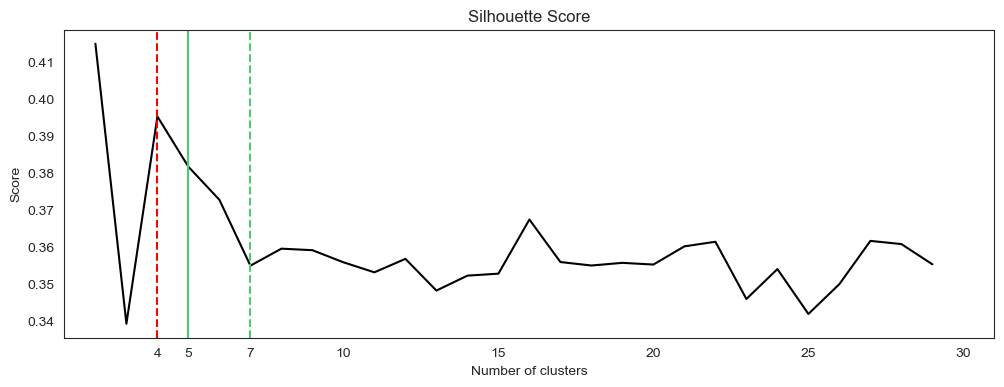

In [24]:
fig = plt.figure(figsize = (12, 4))
ax = fig.add_subplot()
ax.plot(range(2, 30), silhouette, color = 'black')
ax.axvline(4, color = 'red', linestyle = '--')
ax.axvline(5, color = '#50C878')
ax.axvline(7, color = '#50C878', linestyle = '--')
x_ticks = np.append(ax.get_xticks(), [4, 7])
ax.set_xticks(x_ticks)
plt.xlim([1, 31])
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Score')

#### Clustering

In [25]:
kmeans = cluster.KMeans(4)
kmeans.fit(scaled_features)
labels = kmeans.predict(scaled_features)
centroids = kmeans.cluster_centers_

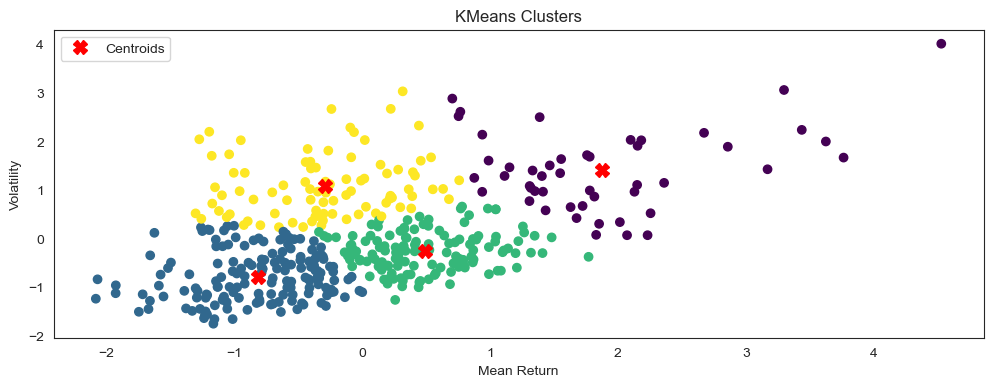

In [26]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot()
ax.scatter(scaled_features.iloc[:,0], scaled_features.iloc[:,1], c = kmeans.labels_,
           cmap = 'viridis')
plt.title('KMeans Clusters')
plt.xlabel('Mean Return')
plt.ylabel('Volatility')

plt.plot(centroids[:, 0], centroids[:, 1], 'Xr', markersize = 10, label = 'Centroids')
plt.legend()
plt.show()

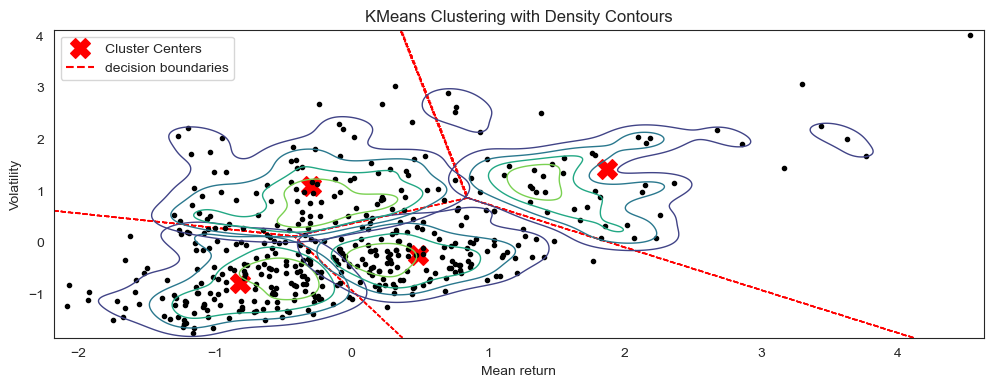

In [27]:
fig = plt.figure(figsize=(12, 4))
plot_kmeans_density(scaled_features.values, labels, kmeans.cluster_centers_)

Text(0.5, 1.0, 'Cluster stock count')

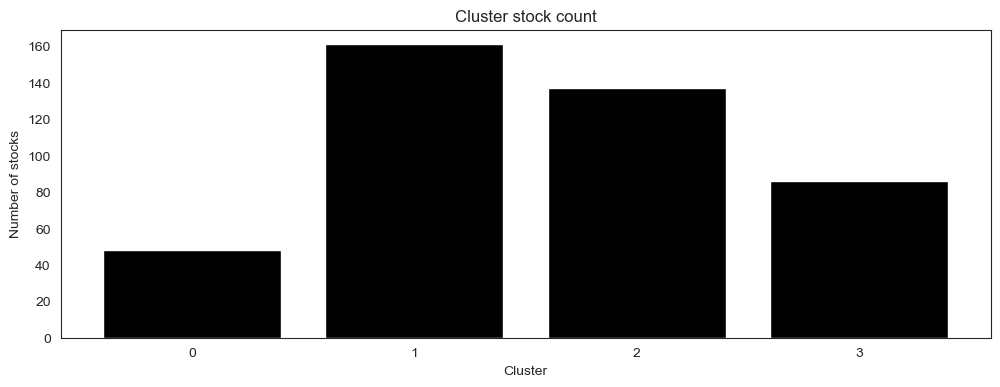

In [28]:
plt.figure(figsize=(12,4))
cluster_counts = np.bincount(labels)
plt.bar(range(len(cluster_counts)), cluster_counts, tick_label=range(len(cluster_counts)), color = 'k')
plt.xlabel('Cluster')
plt.ylabel('Number of stocks')
plt.title('Cluster stock count')

### 1.6.2. Hierarchical Clustering

In [29]:
Z = linkage(scaled_features, method = 'ward')

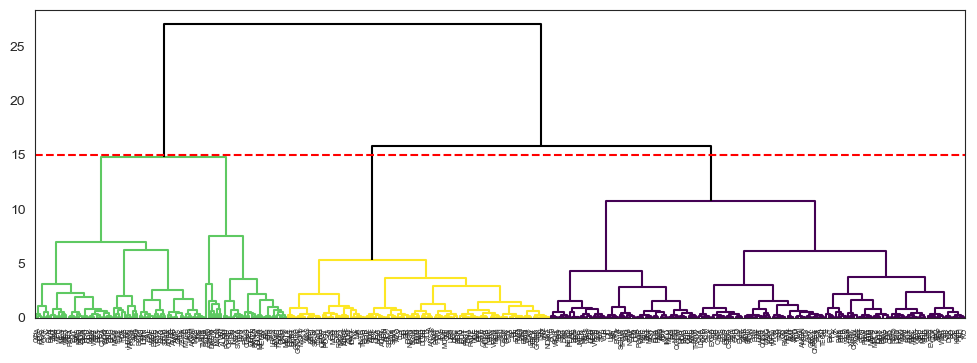

In [30]:
fig = plt.figure(figsize = (12, 4))
ax = fig.add_subplot()
hierarchy.set_link_color_palette(['#5ec962', '#fde725', '#440154', '#3b528b'])
dendrogram(Z, labels = scaled_features.index, color_threshold = 15, above_threshold_color='black')
ax.axhline(15, color = 'red', linestyle = '--')
plt.show()

In [31]:
ag = AgglomerativeClustering(4, affinity = 'euclidean', linkage = 'ward')
hierarchy_labels = ag.fit_predict(scaled_features)

Text(0, 0.5, 'Volatility')

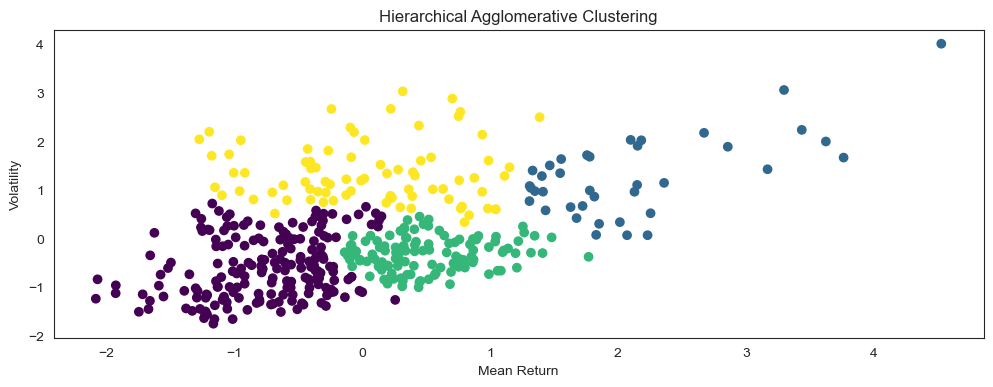

In [32]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot()
ax.scatter(scaled_features.iloc[:,0], scaled_features.iloc[:,1], c = hierarchy_labels,
           cmap = 'viridis')
plt.title('Hierarchical Agglomerative Clustering')
plt.xlabel('Mean Return')
plt.ylabel('Volatility')

Text(0.5, 1.0, 'Cluster stock count')

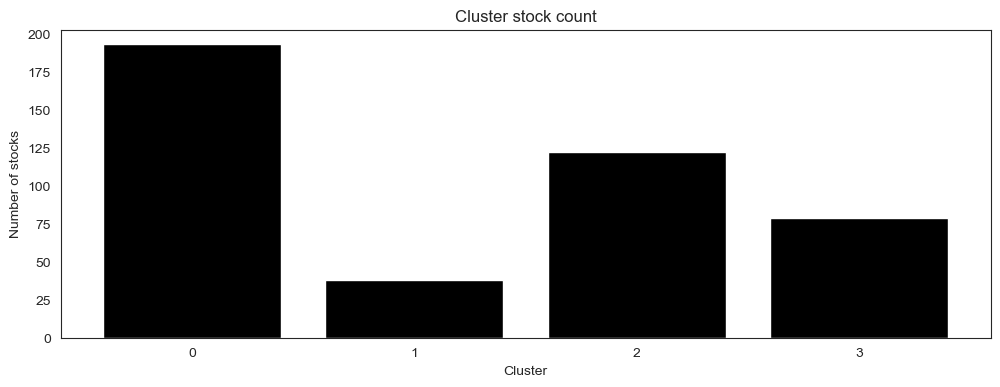

In [33]:
plt.figure(figsize=(12,4))
ag_cluster_counts = np.bincount(hierarchy_labels)
plt.bar(range(len(ag_cluster_counts)), ag_cluster_counts, tick_label=range(len(ag_cluster_counts)), color = 'k')
plt.xlabel('Cluster')
plt.ylabel('Number of stocks')
plt.title('Cluster stock count')

### 1.6.3. Gaussian Mixture Model

#### Hyperparameter selection

In [35]:
gmm_grid = {'n_components': [4, 5, 6, 7]}

gmm_space = {'n_components': np.arange(2, 10, step = 1)}

In [34]:
gaussian_model = GaussianMixture()

In [65]:
gmm_grid_search = GridSearchCV(gaussian_model, gmm_grid, scoring = 'v_measure_score')
gmm_grid_model = gmm_grid_search.fit(scaled_features)

In [67]:
gmm_random_search = RandomizedSearchCV(gaussian_model, gmm_space, scoring = 'v_measure_score')
gmm_random_model = gmm_random_search.fit(scaled_features)

In [68]:
print('Best GridSearchCV hyperparameters are: '+str(gmm_grid_model.best_params_))
print('Best RandomizedSearchCV hyperparameters are: '+str(gmm_random_model.best_params_))

Best GridSearchCV hyperparameters are: {'n_components': 4}
Best RandomizedSearchCV hyperparameters are: {'n_components': 2}


#### Clustering

In [74]:
gmm_grid_components = gmm_grid_model.best_params_['n_components']
gmm_random_components = gmm_random_model.best_params_['n_components']

In [75]:
gmm_model_tuned = GaussianMixture(n_components = gmm_grid_components)
gmm_labels_tuned = gmm_model_tuned.fit_predict(scaled_features)

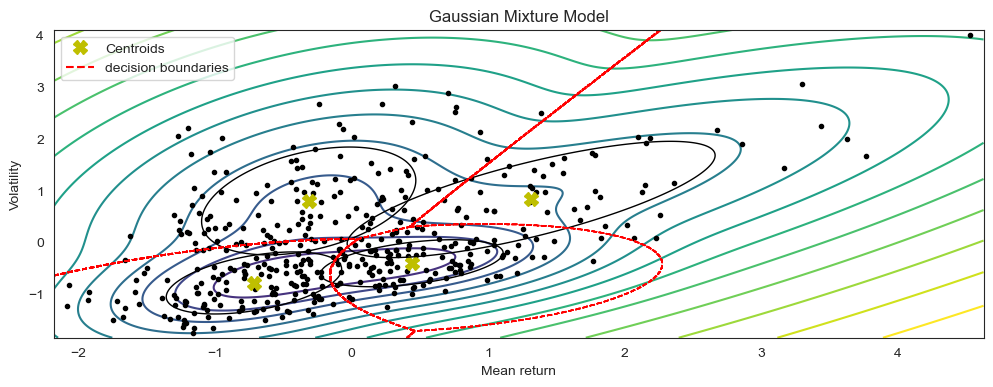

In [78]:
fig = plt.figure(figsize = (12, 4))
plot_gmm(gmm_model_tuned, scaled_features.values, gmm_labels_tuned, gmm_model_tuned.means_,
         gmm_model_tuned.covariances_)

### 1.6.4. Affinity Propagation

#### Hyperparameters tuning

In [79]:
ap_model = AffinityPropagation()

In [80]:
aff_grid = {
    'damping': [.5, .7, .8, 1.0],
    'max_iter': [200, 300, 400, 500],
    'convergence_iter': [10, 13, 15, 17, 20]
}

aff_space = {
    'damping': np.arange(.5, 1.0, step = .1),
    'max_iter': np.arange(100, 500, step = 50),
    'convergence_iter': np.arange(10, 30, step = 5)
}

In [81]:
aff_grid_search = GridSearchCV(ap_model, aff_grid, scoring = 'v_measure_score')
aff_grid_model = aff_grid_search.fit(scaled_features)

In [98]:
aff_random_search = RandomizedSearchCV(ap_model, aff_space, scoring = 'v_measure_score')
aff_random_model = aff_random_search.fit(scaled_features)

In [99]:
print('Best GridSearchCV hyperparameters are: '+str(aff_grid_search.best_params_))
print('Best RandomizedSearchCV hyperparameters are: '+str(aff_random_model.best_params_))

Best GridSearchCV hyperparameters are: {'convergence_iter': 10, 'damping': 0.5, 'max_iter': 200}
Best RandomizedSearchCV hyperparameters are: {'max_iter': 100, 'damping': 0.5, 'convergence_iter': 20}


In [100]:
random_damping = aff_random_model.best_params_['damping']
random_max_iter = aff_random_model.best_params_['max_iter']
random_conv_iter = aff_random_model.best_params_['convergence_iter']

#### Clustering

In [101]:
ap_model_tuned = AffinityPropagation(damping = random_damping, max_iter = random_max_iter, 
                                    convergence_iter = random_conv_iter)
ap_labels_tuned = ap_model_tuned.fit_predict(scaled_features)
exemplars = ap_model_tuned.cluster_centers_indices_

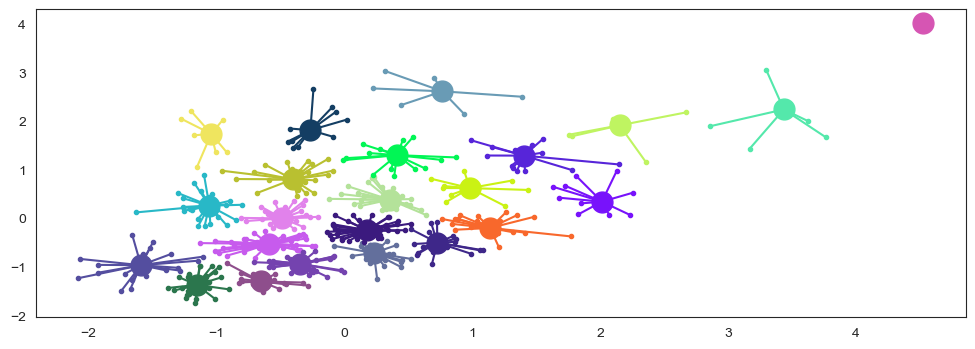

In [104]:
len_exemplars = len(exemplars)


fig = plt.figure(figsize = (12, 4))

number_of_colors = 60

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]

for i, j in zip(range(len_exemplars), color):
    mems = ap_labels_tuned == i
    cluster_center = scaled_features.values[exemplars[i]]
    plt.plot(scaled_features.values[mems, 0], scaled_features.values[mems, 1], marker='.', linestyle = '',
             color = j)
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor = j, markeredgecolor = j , markersize = 15)
    for k in scaled_features.values[mems]:
        plt.plot([cluster_center[0], k[0]], [cluster_center[1], k[1]], color = j)

plt.show()

### 1.6.5. BIRCH Model


#### Hyperparameters tuning

In [105]:
birch_model = Birch()

In [106]:
birch_grid = {
    'threshold': [.3, .5, .7, .9],
    'branching_factor': [30, 40, 50, 60, 70],
    'n_clusters': [4, 5, 6, 7]
}

birch_space = {
    'threshold': np.arange(.2, 1.5, step = .1),
    'branching_factor': np.arange(20, 150, step = 10),
    'n_clusters': np.arange(3, 7, step = 1)
}

In [107]:
birch_grid_search = GridSearchCV(birch_model, birch_grid, scoring = 'v_measure_score')
birch_grid_model = birch_grid_search.fit(scaled_features)

In [108]:
birch_random_search = RandomizedSearchCV(birch_model, birch_space, scoring = 'v_measure_score')
birch_random_model = birch_random_search.fit(scaled_features)

In [111]:
print('Best GridSearchCV hyperparameters are: '+str(birch_grid_search.best_params_))
print('Best RandomizedSearchCV hyperparameters are: '+str(birch_random_model.best_params_))

Best GridSearchCV hyperparameters are: {'branching_factor': 30, 'n_clusters': 4, 'threshold': 0.3}
Best RandomizedSearchCV hyperparameters are: {'threshold': 1.3000000000000003, 'n_clusters': 3, 'branching_factor': 30}


In [112]:
random_threshold = birch_random_model.best_params_['threshold']
random_branching_factor = birch_random_model.best_params_['branching_factor']
random_n_clusters = birch_random_model.best_params_['n_clusters']

#### Clustering

In [113]:
birch_model_tuned = Birch(threshold = random_threshold, branching_factor = random_branching_factor, 
                                    n_clusters = random_n_clusters)
birch_labels_tuned = birch_model_tuned.fit_predict(scaled_features)

Text(0, 0.5, 'Volatility')

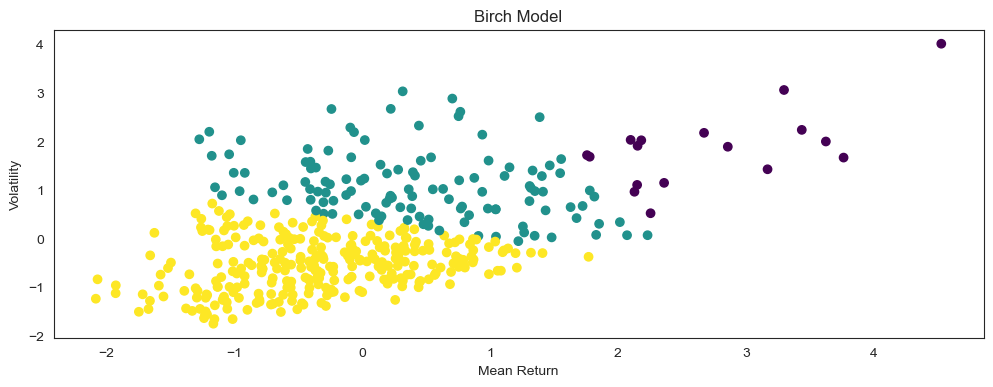

In [114]:
fig = plt.figure(figsize = (12, 4))
ax = fig.add_subplot()
ax.scatter(scaled_features.iloc[:,0], scaled_features.iloc[:,1], c = birch_labels_tuned, cmap = 'viridis')
plt.title('Birch Model')
plt.xlabel('Mean Return')
plt.ylabel('Volatility')

##  2)  Evaluating Clustering Models

In [115]:
print('KMeans Silhouette Score:', metrics.silhouette_score(scaled_features.values, labels))
print('Hierarchical Clustering Silhouette Score:', metrics.silhouette_score(scaled_features.values, hierarchy_labels))
print('Gaussian Mixture Silhouette Score:', metrics.silhouette_score(scaled_features.values, gmm_labels_tuned))
print('Affinity Propagation Silhouette Score:', metrics.silhouette_score(scaled_features.values, ap_labels_tuned))
print('Birch Silhouette Score:', metrics.silhouette_score(scaled_features.values, birch_labels_tuned))

KMeans Silhouette Score: 0.3952729873401171
Hierarchical Clustering Silhouette Score: 0.3567497079541775
Gaussian Mixture Silhouette Score: 0.3579579855339479
Affinity Propagation Silhouette Score: 0.3455660832794949
Birch Silhouette Score: 0.3884740951951513


In [116]:
print("KMeans Davies-Bouldin Index:", metrics.davies_bouldin_score(scaled_features.values, labels))
print("Hierarchical Clustering Davies-Bouldin Index:", metrics.davies_bouldin_score(scaled_features.values, hierarchy_labels))
print("Gaussian Mixture Davies-Bouldin Index:", metrics.davies_bouldin_score(scaled_features.values, gmm_labels_tuned))
print("Affinity Propagation Davies-Bouldin Index:", metrics.davies_bouldin_score(scaled_features.values, ap_labels_tuned))
print("Birch Silhouette Score Davies-Bouldin Index:", metrics.davies_bouldin_score(scaled_features.values, birch_labels_tuned))

KMeans Davies-Bouldin Index: 0.8073879428241859
Hierarchical Clustering Davies-Bouldin Index: 0.8944672914514963
Gaussian Mixture Davies-Bouldin Index: 0.8406341147165317
Affinity Propagation Davies-Bouldin Index: 0.7895972183528122
Birch Silhouette Score Davies-Bouldin Index: 0.9288648230688864


In [117]:
print("KMeans Calinski-Harabasz Index:", metrics.calinski_harabasz_score(scaled_features.values, labels))
print("Hierarchical Clustering Calinski-Harabasz Index:", metrics.calinski_harabasz_score(scaled_features.values, hierarchy_labels))
print("Gaussian Mixture Calinski-Harabasz Index:", metrics.calinski_harabasz_score(scaled_features.values, gmm_labels_tuned))
print("Affinity Propagation Calinski-Harabasz Index:", metrics.calinski_harabasz_score(scaled_features.values, ap_labels_tuned))
print("Birch Silhouette Score Calinski-Harabasz Index:", metrics.calinski_harabasz_score(scaled_features.values, birch_labels_tuned))

KMeans Calinski-Harabasz Index: 366.65753622194313
Hierarchical Clustering Calinski-Harabasz Index: 319.84679764416006
Gaussian Mixture Calinski-Harabasz Index: 310.5023847056117
Affinity Propagation Calinski-Harabasz Index: 388.2310200984937
Birch Silhouette Score Calinski-Harabasz Index: 247.76634484053363


In [118]:
def dunn_index(X, labels):
    min_intercluster_distance = np.inf
    max_intracluster_distance = -np.inf
    
    for i in np.unique(labels):
        cluster_points = X[labels == i]
        intracluster_distance = metrics.pairwise_distances(cluster_points).max()
        max_intracluster_distance = max(max_intracluster_distance, intracluster_distance)
        
        for j in np.unique(labels):
            if i != j:
                other_cluster_points = X[labels == j]
                intercluster_distance = metrics.pairwise_distances(cluster_points, other_cluster_points).min()
                min_intercluster_distance = min(min_intercluster_distance, intercluster_distance)
                
    return min_intercluster_distance / max_intracluster_distance

In [119]:
print("KMeans Dunn Index:", dunn_index(scaled_features.values, labels))
print("Affinity Propagation Dunn Index:", dunn_index(scaled_features.values, ap_labels_tuned))

KMeans Dunn Index: 0.016418875470199632
Affinity Propagation Dunn Index: 0.01587702515832592
